# Parabolic Equations

A typical parabolic equation is the diffusion equation. A typcical parabolic equation might look like this:

$$ \frac{\partial n}{\partial t}  = D \frac{\partial^2 n}{\partial x^2}$$

$$ \frac{n[i+1,j] - n[i,j]}{\Delta t} \approx D \frac{ n[i,j+1] - 2*n[i,j] + n[i, j-1]}{\Delta x^2} $$

Where $D$ is the diffusion constant.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani


## Diffusion



<IPython.core.display.Javascript object>


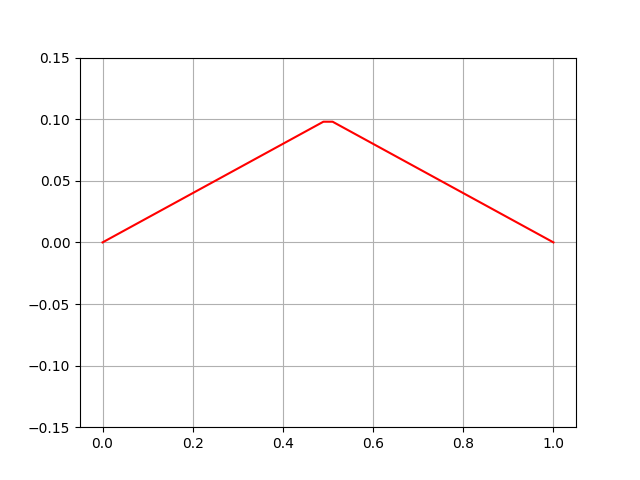

In [2]:

L = 1  # length of string
N = 50 # number of chunks
c = 1.0 # speed
A = 0.1 # amplitude of "pluck"

x = np.linspace(0,L,N)

dx = x[1] - x[0] # what is dx?
y = np.where(x<L/2, x*2*A/L, (L-x)*2*A/L)

fig1, ax1 = plt.subplots()
ax1.plot(x,y,'r-')
ax1.grid()
#ax1.set_aspect('equal')
plt.ylim(-.15,0.15)
plt.show()


The goal of this project is to simulate the time evolution of the plucked string.

In [3]:
L = 1  # length of string
N = 50 # number of chunks
c = 1.0 # speed
A = 0.1 # amplitude of "pluck"

past = 0
present = 1
future = 2

x = np.linspace(0,L,N)
dx = x[1] - x[0] # what is dx?

dt = 0.5*dx/c  # this ensures that dx/dt > c

yp = np.where(x<L/2, x*2*A/L, (L-x)*2*A/L)

y = np.zeros((3,N),float)

y[present] = yp
y[future] = np.zeros((1,N))


In [4]:
y.shape

(3, 50)

$$ c^2 \frac{\partial^2 y}{\partial x^2} = \frac{\partial ^2 y}{\partial t^2} $$

    c**2 (y[j,i+1] - 2*y[j, i] + y[j,i-1])/dx**2 = (y[j+1,i] - 2*y[j,i] + y[j-1,i])/dt**2  (1)
    
We want to solve [1] for y of the future, in other words y[j+1,i].

    c**2*dt**2(y[j,i+1] - 2*y[j, i] + y[j,i-1])/dx**2 = (y[j+1,i] - 2*y[j,i] + y[j-1,i])   (2)
    
    y[j+1,i] = c**2*dt**2(y[j,i+1] - 2*y[j, i] + y[j,i-1])/dx**2 + 2*y[j,i] - y[j-1,i]     (3)



In [5]:
def doStep(y,isFirst=None, future=2, present=1, past=0):
    for i in range(1,N-1):
        if isFirst:
            y[future, i] = (2*y[present, i] + dt**2*c**2*(y[present,i-1] - 2*y[present,i] + y[present,i+1])/dx**2)/2.0
        else:
            y[future, i] = (2*y[present, i] - y[past, i] + dt**2*c**2*(y[present,i-1] - 2*y[present,i] + y[present,i+1])/dx**2)

    return y


In [6]:
y = np.zeros((3,N),float)

y[0] = yp

savedYs = []

for i in range(200):
    y = doStep(y, i==0, (i+1)%3, (i)%3, (i-1)%3)
    savedYs.append(np.copy(y[(i+1)%3]))


<IPython.core.display.Javascript object>


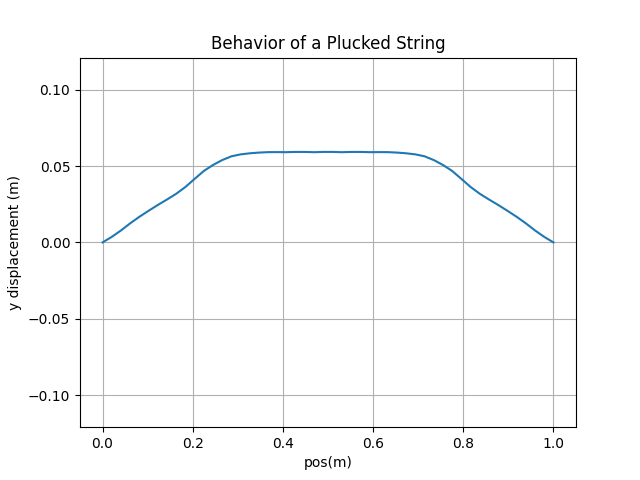

In [7]:
fig, ax = plt.subplots()
ax.grid()
#ax.set_aspect('equal')
plt.xlabel('pos(m)')
plt.ylabel('y displacement (m)')
plt.title('Behavior of a Plucked String')

l, = ax.plot([x[0],x[-1]],[-1.1*A,1.1*A]) # note that this initial plot is just to establish the frame size.

animate = lambda i: l.set_data(x, savedYs[i])

_ = ani.FuncAnimation(fig, animate, frames=len(savedYs), interval=10, repeat=True)

plt.show()

We want to solve this equation:

$$ c^2 \frac{\partial^2 y}{\partial x^2} = \frac{\partial ^2 y}{\partial t^2} $$

Let's propose a likely solution (this is sometimes called separation of variables):

$$y = A*sin(k*x)*cos(\omega*t) $$

What are the derivatives?

$$ \frac{\partial^2 y}{\partial x^2} = -k^2*y $$

$$ \frac{\partial^2 y}{\partial t^2} = -\omega^2*y$$


$$ c^2 (k^2) = \omega^2$$

$$ \frac{\omega}{k} = \frac{\frac{2 \pi}{T}}{\frac{2 \pi}{\lambda}} = \frac{\lambda}{T} = c $$



In [8]:
M=20
A = 0.1
def basis(x, n):
    return np.sqrt(2/L)*np.sin(n*np.pi*x/L)

k1 = np.pi/L
c = 1.0

omega1 = c*k1
T = 2*np.pi/omega1

#
# Compute the Fourier coefficients
#

coefs_th = [0]
for n in range(1,M):
    #
    # This is for a string plucked in the middle.
    #
    
    if n%2==0:
        coefs_th.append(0.0)
    else:
        coefs_th.append(4*A*np.sqrt(2*L)*(-1)**((n-1)/2.0)/(np.pi**2*n**2))  # compare theory


def calcFourierSuperposition(t, nMax=M, singleTerm=None):
    #
    # get superposition at time `t`.
    #
    # if singleTerm is not None, only compute that single Term!
    #
    
    sup = np.zeros(N)
    
    if singleTerm is None:
        ys = [[]]
        for n in range(1,nMax):
            ys.append(coefs_th[n]*basis(x,n))
            sup += ys[n]*np.cos(omega1*n*t)
    else:
        sup += coefs_th[singleTerm]*basis(x,singleTerm)*np.cos(omega1*singleTerm*t)

    return sup

#
# Compute a solution with 20 terms
# 
savedYs = []
for t in np.linspace(0, T, 200):
    savedYs.append(calcFourierSuperposition(t))


<IPython.core.display.Javascript object>


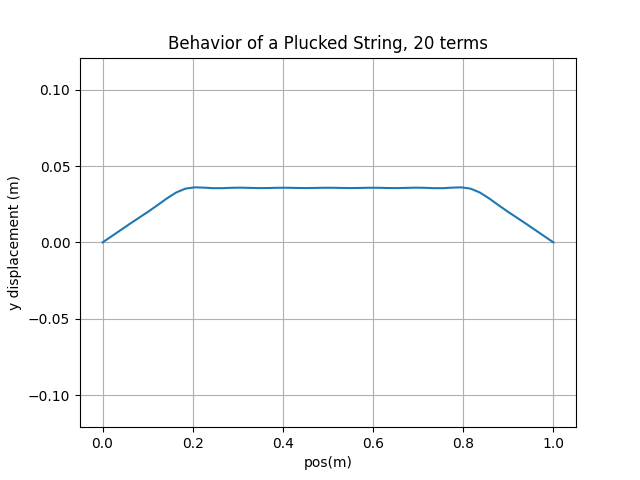

In [9]:
#
# Animate the 20 term solution using the same approach as before
#

fig, ax = plt.subplots()
ax.grid()
#ax.set_aspect('equal')
plt.xlabel('pos(m)')
plt.ylabel('y displacement (m)')
plt.title('Behavior of a Plucked String, 20 terms')

l, = ax.plot([x[0],x[-1]],[-1.1*A,1.1*A]) # note that this initial plot is just to establish the frame size.

animate = lambda i: l.set_data(x, savedYs[i])

_ = ani.FuncAnimation(fig, animate, frames=len(savedYs), interval=10, repeat=True)

plt.show()

In [10]:
#
# Now, just focus on n=1, n=3, and the superposition of n=1 and n=3
#
savedY1s = []
savedY3s = []
savedYs = []

for t in np.linspace(0, T, 200):
    savedY1s.append(calcFourierSuperposition(t,singleTerm=1))
    savedY3s.append(calcFourierSuperposition(t,singleTerm=3))
    savedYs.append(calcFourierSuperposition(t,nMax=4))


<IPython.core.display.Javascript object>


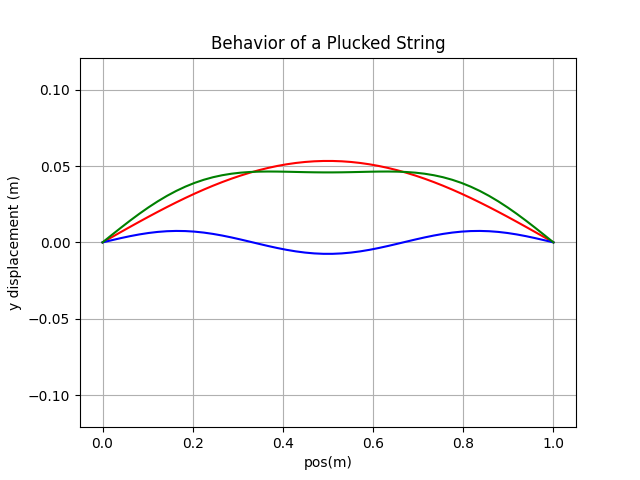

In [11]:
fig, ax = plt.subplots()
ax.grid()
#ax.set_aspect('equal')
plt.xlabel('pos(m)')
plt.ylabel('y displacement (m)')
plt.title('Behavior of a Plucked String')

l1, = ax.plot([x[0],x[-1]],[-1.1*A,1.1*A],'r-') # n=1, red
l3, = ax.plot([x[0],x[-1]],[-1.1*A,1.1*A],'b-') # n=3, blue
lt, = ax.plot([x[0],x[-1]],[-1.1*A,1.1*A],'g-') # n=1 + n=3, superposition, green

def animate(i):
    l1.set_data(x,savedY1s[i])
    l3.set_data(x,savedY3s[i])
    lt.set_data(x,savedYs[i])

_ = ani.FuncAnimation(fig, animate, frames=len(savedYs), interval=10, repeat=True)

plt.show()

Note that the qualitative behavior of the full solution is already present in only *two* terms!